In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import geopandas as gpd
import contextily as cx
import os
import seaborn as sns
import shapely as shp

In [10]:
# Distance totale

for csv_file in os.listdir("./data_clean"):
    if csv_file[-3:] == "csv":
        globals()[csv_file[:-4]] = pd.read_csv("./data_clean/" + csv_file)

# Diagnostic

## Exemple de routes absurdes

In [11]:
warehouse = "Cergy"
date = "2021-01-04 00:00:00"

sub_routes = routes[(routes["from_warehouse"] == warehouse) & (routes["route_date"]==date[:10])]

In [12]:
sub_routes

,Unnamed: 0,truck_id,duration,fill_volume,n_units,orders,from_warehouse,route_date,stops,total_distance
13,13,5nYoqzUpcuKCxHcJud5XnP,22.426140,32.6702,304.0,Q3HkTWxsAkyiVzUZdR6F7i > 9UQhgWxUibbkGHLgMWmXB...,Cergy,2021-01-04,Cergy > Versailles > Tours > Saint-Nazaire > S...,1222.750703
14,14,PakZTNLpBwse7peo8v7jAG,23.151776,40.9950,494.0,Q2ujTYZAnSEMAwrrYbysaA > KupPC4Y7bqZTPYzWWFFA2...,Cergy,2021-01-04,Cergy > Pantin > Orléans > Nanterre > Montreui...,809.509761
15,15,nVFrbdAtjeuNm9ErK2wusU,14.392238,26.4638,318.0,X5MDVyWx4NodKo9TfZgi74 > 7aeUWpkbtiEJYDFpW8UAH...,Cergy,2021-01-04,Cergy > Calais > Caen > Boulogne-Billancourt >...,942.604514


In [13]:
def create_path(stops):
    stops = stops.split(" > ")
    coordinates = []
    for stop in stops:
        city = cities[cities["city"] == stop].iloc[0]
        coordinates.append([city["lng"], city["lat"]])
    if len(coordinates) == 1:
        coordinates = 2*coordinates
    return shp.geometry.LineString(coordinates)

In [16]:
sub_routes["path"] = sub_routes["stops"].apply(create_path)

/var/folders/lr/pr9gn1c11knd9lzmwj4tmst00000gn/T/ipykernel_78038/3006919847.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_routes["path"] = sub_routes["stops"].apply(create_path)


In [17]:
sub_routes

,Unnamed: 0,truck_id,duration,fill_volume,n_units,orders,from_warehouse,route_date,stops,total_distance,path
13,13,5nYoqzUpcuKCxHcJud5XnP,22.426140,32.6702,304.0,Q3HkTWxsAkyiVzUZdR6F7i > 9UQhgWxUibbkGHLgMWmXB...,Cergy,2021-01-04,Cergy > Versailles > Tours > Saint-Nazaire > S...,1222.750703,"LINESTRING (2.0631 49.0361, 2.135 48.8053, 0.6..."
14,14,PakZTNLpBwse7peo8v7jAG,23.151776,40.9950,494.0,Q2ujTYZAnSEMAwrrYbysaA > KupPC4Y7bqZTPYzWWFFA2...,Cergy,2021-01-04,Cergy > Pantin > Orléans > Nanterre > Montreui...,809.509761,"LINESTRING (2.0631 49.0361, 2.4017 48.8966, 1...."
15,15,nVFrbdAtjeuNm9ErK2wusU,14.392238,26.4638,318.0,X5MDVyWx4NodKo9TfZgi74 > 7aeUWpkbtiEJYDFpW8UAH...,Cergy,2021-01-04,Cergy > Calais > Caen > Boulogne-Billancourt >...,942.604514,"LINESTRING (2.0631 49.0361, 1.8564 50.9481, -0..."


In [42]:
sub_routes["fill_rate"] = (sub_routes["fill_volume"] / 81.25 * 100).apply(lambda x:f"{x:.2f}%")

/var/folders/lr/pr9gn1c11knd9lzmwj4tmst00000gn/T/ipykernel_78038/655986612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_routes["fill_rate"] = (sub_routes["fill_volume"] / 81.25 * 100).apply(lambda x:f"{x:.2f}%")


In [58]:
new_cmap = matplotlib.colors.ListedColormap([[0/255, 169/255, 244/255], [2/255, 28/255, 44/255]])

def f(provider):
    fig, ax = plt.subplots(figsize=(20, 20))

    sub_routes_ = sub_routes[:2]

    sub_cities =  cities[cities["city"].isin(sub_routes_.stops.str.split(" > ").explode())]

    gdf_cities = gpd.GeoDataFrame(sub_cities, 
                                geometry=gpd.points_from_xy(sub_cities.lng, sub_cities.lat), crs=4326)
    gdf_cities.to_crs(epsg=3857).plot(ax=ax, column="is_warehouse", markersize=50)

    gdf = gpd.GeoDataFrame(sub_routes_, geometry=sub_routes_.path, crs=4326)
    gdf.to_crs(epsg=3857).plot(ax=ax, column="fill_rate", linewidth=5, legend=False, cmap=new_cmap)

    cx.add_basemap(ax, source=eval(f"cx.providers.{provider}"), zoom=8)
    ax.axis('off')
    ax.set_title("Localisation des villes")
    plt.show()

In [30]:
selection = ['OpenStreetMap.Mapnik',
             'OpenTopoMap',
             'Stamen.Toner',
             'Stamen.TonerLite',
             'Stamen.Terrain',
             'Stamen.TerrainBackground',
             'Stamen.Watercolor',
             'NASAGIBS.ViirsEarthAtNight2012',
             'CartoDB.Positron',
             'CartoDB.Voyager'
            ]

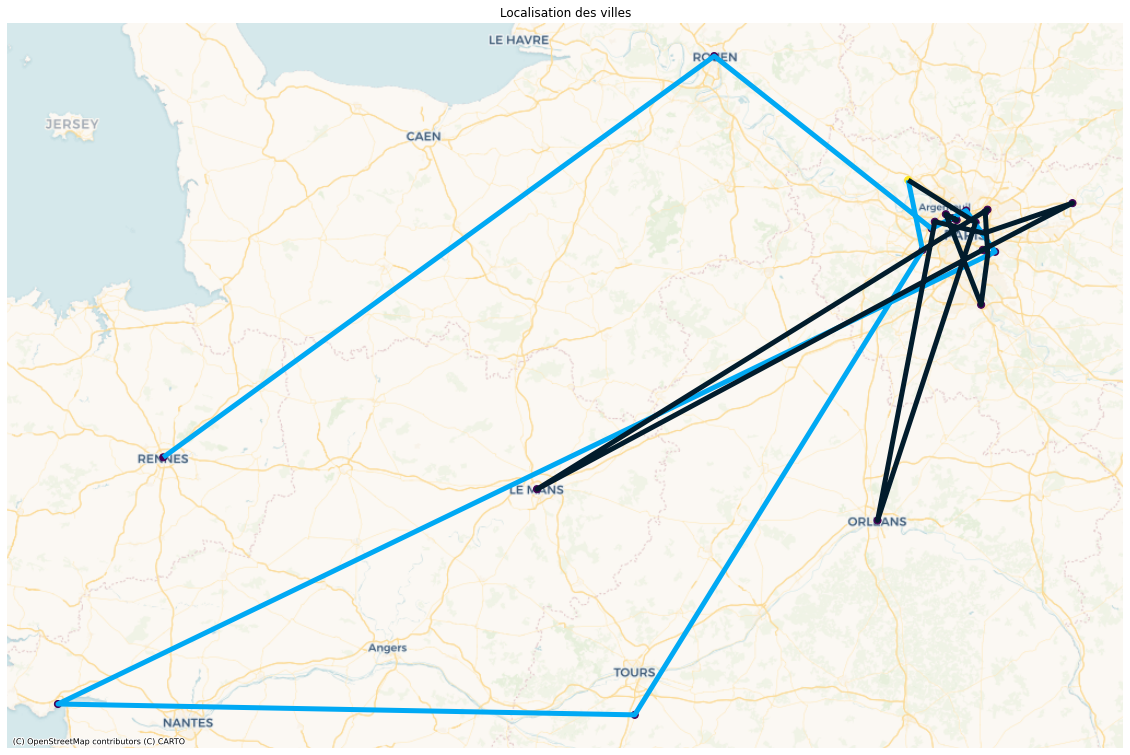

In [59]:
f(selection[-1])